# Titanic - Machine Learning from Disaster

Attempting to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (i.e. name, age, gender, socio-economic class, etc).

## Imports

In [685]:
import opendatasets as od

In [686]:
import pandas as pd

In [687]:
import numpy as np

In [688]:
import matplotlib.pyplot as plt

In [689]:
from scipy.stats import skew

In [690]:
import seaborn as sns

In [691]:
import math
from matplotlib.patches import Rectangle

## 1. Getting the Data

In [692]:
!pip install opendatasets

In [693]:
od.download("https://www.kaggle.com/competitions/titanic/data")


Skipping, found downloaded files in ".\titanic" (use force=True to force download)


Here is our training set:

In [694]:
train_set = pd.read_csv('titanic/train.csv')

And here is our test set:

In [695]:
test_set = pd.read_csv('titanic/test.csv')

Below is a set of data in which survival predictions are made on gender. This should amount to something like a 50% survival rate.

In [696]:
survived = pd.read_csv('titanic/gender_submission.csv')

Now it's time for our second step - studying the data more in depth!

## 2. Studying the Data

Let's start with a quick look at the data to make sure it is all good:

In [697]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Looks thick, solid and tight. How many rows are there in the sets?

In [698]:
print('Number of rows in training set: ' + str(len(train_set)))
print('Number of rows in test set:     ' + str(len(test_set)))

Number of rows in training set: 891
Number of rows in test set:     418


Perhaps not the ideal 80/20 split, but oh well. What data types are we dealing with?

In [699]:
train_set.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Let's take a look at what data is missing.

### Missing data

In [700]:
print('EMPTY ROWS:\n')

for category in train_set:
    null_values = len(np.where(pd.isnull(train_set[category]))[0])
    print(category +  ": " + str(null_values) + ", " + str(math.ceil(null_values/len(train_set) * 100)) + '%')

EMPTY ROWS:

PassengerId: 0, 0%
Survived: 0, 0%
Pclass: 0, 0%
Name: 0, 0%
Sex: 0, 0%
Age: 177, 20%
SibSp: 0, 0%
Parch: 0, 0%
Ticket: 0, 0%
Fare: 0, 0%
Cabin: 687, 78%
Embarked: 2, 1%


In [701]:
#TODO: Try making this a DataFrame instead

Seems like there are three rows that need some action; 'Age', 'Cabin' and 'Embarked'.

'Age' has a medium amount of missing values, 'Cabin' is largely missing altogether, while 'Embarked' is mostly filled out. These will all be handled in section 3.

In [702]:
#TODO: Data visualization, other forms of looking at the data

Let's try and visualize deaths and age in histograms:

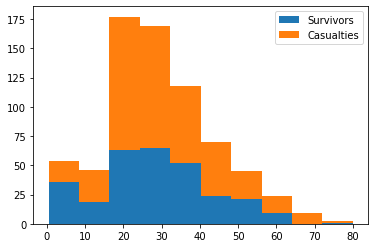

In [703]:
survivors = train_set.loc[train_set['Survived'] == 1]
casualties = train_set.loc[train_set['Survived'] == 0]

plt.hist([survivors['Age'], casualties['Age']], stacked=True)
plt.legend(['Survivors', 'Casualties'])
plt.show()

Seems like we're onto something here. Let's look closer at these percentages!

In [704]:
# Lil' function to get passengers in certain age ranges
def get_passengers_by_age(df, age, span):
    return df[df['Age'].between(age, age + span, "both")]

In [724]:
# We have to do a little data trickery here because we have an age span of 81 years - don't tell anyone!
survivors['Age'].apply(np.ceil)
casualties['Age'].apply(np.ceil)
survivors.dropna(subset=['Age'])
casualties.dropna(subset=['Age'])

span = 8
total_survivors = 0
total_casualties = 0

print("\nSurvivors: ")
for n in range(10):
    print("Age span: " + str(n * span + 1) + " - " + str(n * span + span))
    print(len(get_passengers_by_age(survivors, span * n + 1, span)))
    total_survivors += len(get_passengers_by_age(survivors, span * n + 1, span))


print("\nCasualties: ")
for n in range(10):
    print("Age span: " + str(n * span + 1) + " - " + str(n * span + span))
    print(len(get_passengers_by_age(casualties, span * n + 1, span)))
    total_casualties += len(get_passengers_by_age(casualties, span * n + 1, span))

print("\nThe total of survivors is: " + str(total_survivors))
print("The total of casualties is: " + str(total_casualties))
print("Passengers with no age: " + str(len(np.where(pd.isnull(train_set['Age']))[0])))
print("Thus you have: " + str(total_survivors + total_casualties + len(np.where(pd.isnull(train_set['Age']))[0])))
print("\nSurvivors actual: " + str(len(survivors.dropna(subset=['Age']))))
print("Casualties actual: " + str(len(casualties.dropna(subset=['Age']))))
print("The total amount of passengers: " + str(len(train_set.dropna(subset=['Age']))))


Survivors: 
Age span: 1 - 8
31
Age span: 9 - 16
25
Age span: 17 - 24
69
Age span: 25 - 32
72
Age span: 33 - 40
53
Age span: 41 - 48
28
Age span: 49 - 56
21
Age span: 57 - 64
9
Age span: 65 - 72
0
Age span: 73 - 80
1

Casualties: 
Age span: 1 - 8
24
Age span: 9 - 16
34
Age span: 17 - 24
132
Age span: 25 - 32
113
Age span: 33 - 40
71
Age span: 41 - 48
46
Age span: 49 - 56
26
Age span: 57 - 64
18
Age span: 65 - 72
9
Age span: 73 - 80
1

The total of survivors is: 309
The total of casualties is: 474
Passengers with no age: 0
Thus you have: 783

Survivors actual: 290
Casualties actual: 424
The total amount of passengers: 891


In [706]:
len(train_set[(train_set['Age'] >= 0) & (train_set['Age'] <= 8)])

54

## 3. Preprocessing the data

#### Handling missing data - Age

First we'll deal with the missing data, and we'll start with 'Age'. 

In [707]:
print(train_set['Age'][:20])

0     22.0
1     38.0
2     26.0
3     35.0
4     35.0
5      NaN
6     54.0
7      2.0
8     27.0
9     14.0
10     4.0
11    58.0
12    20.0
13    39.0
14    14.0
15    55.0
16     2.0
17     NaN
18    31.0
19     NaN
Name: Age, dtype: float64


It can safely be assumed that the age of an individual affects survival rate, so we would like to keep this category. That means we'll have to fill it out, with either the mean, median or mode value. Let's check out what they are!

First we'll make a copy of the training set without any missing age values:

In [708]:
train_set_without_missing_age_values = train_set.dropna(subset=['Age'])

###### Mean

In [709]:
no_of_passengers = len(train_set_without_missing_age_values)
sum_of_ages = train_set_without_missing_age_values['Age'].sum()
mean_age = sum_of_ages / no_of_passengers

print('Mean passenger age: ' + str(round(mean_age, 1)) + " years")

Mean passenger age: 29.7 years


##### Median

In [710]:
train_set_by_age = train_set_without_missing_age_values.sort_values(by=['Age'])
no_of_passengers = len(train_set_by_age)
median_age = train_set_by_age['Age'].iloc[math.ceil(no_of_passengers/2)]

print('Median passenger age: ' + str(round(median_age, 1)) + " years")

Median passenger age: 28.0 years


##### Mode

In [711]:
from collections import Counter

no_of_passengers = len(train_set_without_missing_age_values)
value = Counter(train_set_without_missing_age_values['Age'].apply(np.ceil))
findMode = dict(value)
mode_age = [i for i, v in findMode.items() if v == max(list(value.values()))]  

print("Mode passenger age: " + ', '.join(map(str, mode_age)))

Mode passenger age: 24.0


So there is a a difference in ~6 years between the lowest and highest "averages". Which should we choose?

<AxesSubplot:ylabel='Density'>

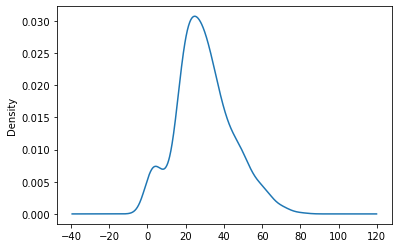

In [712]:
train_set_without_missing_age_values['Age'].plot(kind='kde')

<AxesSubplot:ylabel='Frequency'>

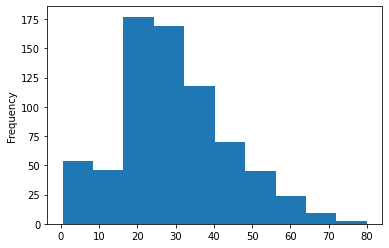

In [713]:
train_set_without_missing_age_values['Age'].plot(kind='hist')

In [714]:
print('Skew: ' + str(skew(train_set_without_missing_age_values['Age'])))

Skew: 0.3882898514698657


Seeing as our data is slightly right skewed, we will fill missing age values with the median age.

(Source: https://statisticsbyjim.com/basics/measures-central-tendency-mean-median-mode/)

In [715]:
train_set_median_age = train_set #TODO: Is this needed?
train_set_median_age['Age'] = train_set['Age'].fillna(median_age)

Let's make sure we didn't screw this up.

In [716]:
train_set_median_age.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Sweet! Onto the next now.

#### Handling missing data - Cabin

80% of the values in this column are missing, so we will simply remove the whole column. Bye bye!

In [717]:
train_set_without_cabin = train_set_median_age.drop('Cabin', inplace=False, axis=1)

In [718]:
train_set_without_cabin.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


#### Handling missing data - Embarked

In this column only two values are missing. Therefore we will fill them with the value that reoccurs the most.

In [719]:
mode_embarked = train_set_without_cabin['Embarked'].mode()[0]

mode_embarked

'S'

In [720]:
train_set_filled = train_set_without_cabin
train_set_filled['Embarked'] = train_set_filled['Embarked'].fillna(mode_embarked)

In [721]:
train_set_filled.isna().sum() 

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Looks good!

In [722]:
train_set_filled.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## 4. Choosing a Model

## 5. Training the Model

## 6.Evaluating the Model

## 7. Tuning the Parameters

## 8. Making a Prediction